# Final Exam - Open

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* The exam is `85` points.
* You have `85` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Final - Open` assignment on Canvas, where you downloaded this. 
* Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers.)
* Your submission should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

- For Section 1:
    * `data/final_exam_data.xlsx`
- for Section 2:
    * `data/fx_rf_data.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 40     |
| 2       | 45     |

### Each numbered question is worth 5 points unless otherwise specified.

***

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
from arch import arch_model
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re
import datetime
from typing import Union, List, Callable, Dict


import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

PLOT_WIDTH, PLOT_HEIGHT = 12, 8

import statsmodels.api as sm
from scipy.stats import t, norm, kurtosis, skew
from scipy.optimize import minimize

import os
import sys

parent_path = os.path.dirname(os.getcwd()) # Get parent path (if using .ipynb file)
# parent_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) # Get parent path (if using .py file)
os.chdir(parent_path) # Set parent path as working directory (for reading and writing files)

## Helper Functions

### Tools

In [2]:
# Title: Tools for Financial Data Analysis


def read_excel_default(excel_name: str,
                       sheet_name: str = None, 
                       index_col : int = 0,
                       parse_dates: bool =True,
                       print_sheets: bool = False,
                       **kwargs):
    """
    Reads an Excel file and returns a DataFrame with specified options.

    Parameters:
    excel_name (str): The path to the Excel file.
    index_col (int, default=0): Column to use as the row index labels of the DataFrame.
    parse_dates (bool, default=True): Boolean to parse dates.
    print_sheets (bool, default=False): If True, prints the names and first few rows of all sheets.
    sheet_name (str or int, default=None): Name or index of the sheet to read. If None, reads the first sheet.
    **kwargs: Additional arguments passed to `pd.read_excel`.

    Returns:
    pd.DataFrame: DataFrame containing the data from the specified Excel sheet.

    Notes:
    - If `print_sheets` is True, the function will print the names and first few rows of all sheets and return None.
    - The function ensures that the index name is set to 'date' if the index column name is 'date', 'dates' or 'datatime', or if the index contains date-like values.
    """

    if print_sheets:
        excel_file = pd.ExcelFile(excel_name)  # Load the Excel file to get sheet names
        sheet_names = excel_file.sheet_names
        n = 0
        while True:
            try:
                sheet = pd.read_excel(excel_name, sheet_name=n)
                print(f'Sheet name: {sheet_names[n]}')
                print("Columns: " + ", ".join(list(sheet.columns)))
                print(sheet.head(3))
                n += 1
                print('-' * 70)
                print('\n')
            except:
                return
    sheet_name = 0 if sheet_name is None else sheet_name
    df = pd.read_excel(excel_name, index_col=index_col, parse_dates=parse_dates,  sheet_name=sheet_name, **kwargs)
    df.columns = [col.lower() for col in df.columns]
    if df.index.name is not None:
        if df.index.name in ['date', 'dates', 'datetime']:
            df.index.name = 'date'
    elif isinstance(df.index[0], (datetime.date, datetime.datetime)):
        df.index.name = 'date'
    return df


def time_series_to_df(returns: Union[pd.DataFrame, pd.Series, List[pd.Series]], name: str = "Returns"):
    """
    Converts returns to a DataFrame if it is a Series or a list of Series.

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.

    Returns:
    pd.DataFrame: DataFrame of returns.
    """
    if isinstance(returns, pd.DataFrame):
        returns = returns.copy()
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    elif isinstance(returns, list):
        returns_list = returns.copy()
        returns = pd.DataFrame({})

        for series in returns_list:
            if isinstance(series, pd.Series):
                returns = returns.merge(series, right_index=True, left_index=True, how='outer')
            else:
                raise TypeError(f'{name} must be either a pd.DataFrame or a list of pd.Series')
            
    # Convert returns to float
    try:
        returns = returns.apply(lambda x: x.astype(float))
    except ValueError:
        print(f'Could not convert {name} to float. Check if there are any non-numeric values')
        pass

    return returns


def fix_dates_index(returns: pd.DataFrame):
    """
    Fixes the date index of a DataFrame if it is not in datetime format and convert returns to float.

    Parameters:
    returns (pd.DataFrame): DataFrame of returns.

    Returns:
    pd.DataFrame: DataFrame with datetime index.
    """
    # Check if 'date' is in the columns and set it as the index

    # Set index name to 'date' if appropriate
    
    if returns.index.name is not None:
        if returns.index.name.lower() in ['date', 'dates', 'datetime']:
            returns.index.name = 'date'
    elif isinstance(returns.index[0], (datetime.date, datetime.datetime)):
        returns.index.name = 'date'
    elif 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    elif 'datetime' in returns.columns.str.lower():
        returns = returns.rename({'Datetime': 'date'}, axis=1)
        returns = returns.rename({'datetime': 'date'}, axis=1)
        returns = returns.set_index('date')

    # Convert dates to datetime if not already in datetime format or if minutes are 0
    try:
        returns.index = pd.to_datetime(returns.index, utc=True)
    except ValueError:
        print('Could not convert the index to datetime. Check the index format for invalid dates.')
    if not isinstance(returns.index, pd.DatetimeIndex) or (returns.index.minute == 0).all():
        returns.index = pd.to_datetime(returns.index.map(lambda x: x.date()))
        
    # Convert returns to float
    try:
        returns = returns.apply(lambda x: x.astype(float))
    except ValueError:
        print('Could not convert returns to float. Check if there are any non-numeric values')
        pass

    return returns


def filter_columns_and_indexes(
    df: pd.DataFrame,
    keep_columns: Union[list, str],
    drop_columns: Union[list, str],
    keep_indexes: Union[list, str],
    drop_indexes: Union[list, str]
):
    """
    Filters a DataFrame based on specified columns and indexes.

    Parameters:
    df (pd.DataFrame): DataFrame to be filtered.
    keep_columns (list or str): Columns to keep in the DataFrame.
    drop_columns (list or str): Columns to drop from the DataFrame.
    keep_indexes (list or str): Indexes to keep in the DataFrame.
    drop_indexes (list or str): Indexes to drop from the DataFrame.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """

    if not isinstance(df, (pd.DataFrame, pd.Series)):
        return df
    
    df = df.copy()

    # Columns
    if keep_columns is not None:
        keep_columns = [re.escape(col) for col in keep_columns]
        keep_columns = "(?i).*(" + "|".join(keep_columns) + ").*" if isinstance(keep_columns, list) else "(?i).*" + keep_columns + ".*"
        df = df.filter(regex=keep_columns)
        if drop_columns is not None:
            print('Both "keep_columns" and "drop_columns" were specified. "drop_columns" will be ignored.')

    elif drop_columns is not None:
        drop_columns = [re.escape(col) for col in drop_columns]
        drop_columns = "(?i).*(" + "|".join(drop_columns) + ").*" if isinstance(drop_columns, list) else "(?i).*" + drop_columns + ".*"
        df = df.drop(columns=df.filter(regex=drop_columns).columns)

    # Indexes
    if keep_indexes is not None:
        keep_indexes = [re.escape(col) for col in keep_indexes]
        keep_indexes = "(?i).*(" + "|".join(keep_indexes) + ").*" if isinstance(keep_indexes, list) else "(?i).*" + keep_indexes + ".*"
        df = df.filter(regex=keep_indexes, axis=0)
        if drop_indexes is not None:
            print('Both "keep_indexes" and "drop_indexes" were specified. "drop_indexes" will be ignored.')

    elif drop_indexes is not None:
        drop_indexes = [re.escape(col) for col in drop_indexes]
        drop_indexes = "(?i).*(" + "|".join(drop_indexes) + ").*" if isinstance(drop_indexes, list) else "(?i).*" + drop_indexes + ".*"
        df = df.filter(regex=keep_indexes, axis=0)
    
    return df

### Returns and Performance Summary

In [3]:
def plot_cumulative_returns(
    cumulative_returns: Union[pd.DataFrame, pd.Series],
    name: str = None
):
    """
    Plots cumulative returns from a time series of cumulative returns.

    Parameters:
    cumulative_returns (pd.DataFrame or pd.Series): Time series of cumulative returns.
    name (str, default=None): Name for the title of the plot.

    Returns:
    None
    """

    # Handle index formatting for hours, minutes, and seconds
    indexes_cum_ret = cumulative_returns.index
    if indexes_cum_ret[0].hour == 0 and indexes_cum_ret[0].minute == 0 and indexes_cum_ret[0].second == 0:
        formatted_index = indexes_cum_ret.strftime('%Y-%m-%d')
    else:
        formatted_index = indexes_cum_ret.strftime('%Y-%m-%d\n%H:%M:%S')

    continuous_index = range(len(indexes_cum_ret))

    # Plot cumulative returns
    fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
    if isinstance(cumulative_returns, pd.Series):
        ax.plot(continuous_index, cumulative_returns, label='Cumulative Returns', linewidth=1.5, color='blue')
    elif isinstance(cumulative_returns, pd.DataFrame):
        for column in cumulative_returns.columns:
            ax.plot(continuous_index, cumulative_returns[column], label=column, linewidth=1.5)
    else:
        raise ValueError("`cumulative_returns` must be a pandas DataFrame or Series.")

    # Format x-axis with formatted dates
    num_ticks = 20
    tick_indices = np.linspace(0, len(continuous_index) - 1, num=num_ticks, dtype=int)
    tick_labels = [formatted_index[i] for i in tick_indices]
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)
    ax.set_xlim([0, len(formatted_index) - 1])

    # Add percentage formatting for y-axis
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=2))

    # Add zero line
    ax.axhline(0, color='darkgrey', linewidth=1, linestyle='-')
    ax.set_title(f'Cumulative Returns {name}' if name else 'Cumulative Returns', fontsize=14)

    # Style grid and background
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(fontsize=10)

    # Show the plot
    plt.show()



def calc_cumulative_returns(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    plot_returns: bool = True,
    name: str = None,
    return_series: bool = True,
    timeframes: Union[None, dict] = None
):
    """
    Calculates cumulative returns from a time series of returns.

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    plot_returns (bool, default=True): If True, plots the cumulative returns.
    name (str, default=None): Name for the cumulative return series.
    return_series (bool, default=True): If True, returns the cumulative returns as a Series.
    timeframes (dict or None, default=None): Dictionary of timeframes to calculate cumulative returns for each period.
    
    Returns:
    pd.DataFrame: Returns cumulative returns DataFrame
    """

    returns = time_series_to_df(returns)  # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns)  # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if timeframes is not None:
        results = {}
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()

            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')

            cumulative_returns = calc_cumulative_returns(
                timeframe_returns,
                return_series=True,
                plot_returns=plot_returns,
                name=name,
                timeframes=None
            )
            results[name] = cumulative_returns
        return results

    cumulative_returns = (1 + returns).cumprod() - 1

    if plot_returns:
        plot_cumulative_returns(cumulative_returns, name=name)

    if return_series:
        return cumulative_returns
    

def calc_returns_statistics(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    annual_factor: int = None,
    provided_excess_returns: bool = None,
    rf_returns: Union[pd.Series, pd.DataFrame] = None,
    var_quantile: Union[float , List] = .05,
    timeframes: Union[None, dict] = None,
    return_tangency_weights: bool = False,
    correlations: Union[bool, List] = False,
    tail_risks: bool = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    _timeframe_name: str = None,
):
    """
    Calculates summary statistics for a time series of returns.   

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    provided_excess_returns (bool, default=None): Whether excess returns are already provided.
    rf (pd.Series or pd.DataFrame, default=None): Risk-free rate data.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    timeframes (dict or None, default=None): Dictionary of timeframes [start, finish] to calculate statistics for each period.
    return_tangency_weights (bool, default=True): If True, returns tangency portfolio weights.
    correlations (bool or list, default=True): If True, returns correlations, or specify columns for correlations.
    tail_risks (bool, default=True): If True, include tail risk statistics.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: Summary statistics of the returns.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if rf_returns is not None:
        rf_returns = time_series_to_df(rf_returns) # Convert returns to DataFrame if it is a Series
        fix_dates_index(rf_returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float
        rf_returns = rf_returns.reindex(returns.index).dropna()
        
        if len(rf_returns.index) != len(returns.index):
            raise Exception('"rf_returns" has missing data to match "returns" index')
        if type(rf_returns) == pd.DataFrame:
            rf = rf_returns.iloc[:, 0].to_list()
        elif type(rf_returns) == pd.Series:
            rf = rf_returns.to_list()

    # Assume annualization factor of 12 for monthly returns if None and notify user
    if annual_factor is None:
        print('Assuming monthly returns with annualization term of 12')
        annual_factor = 12

    
    if keep_columns is None:
        keep_columns = ['Accumulated Return', 'Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Min', 'Mean', 'Max', 'Correlation']
        if tail_risks == True:
            keep_columns += ['Skewness', 'Excess Kurtosis', f'Historical VaR', f'Annualized Historical VaR', 
                                f'Historical CVaR', f'Annualized Historical CVaR', 'Max Drawdown', 
                                'Peak Date', 'Bottom Date', 'Recovery', 'Duration (days)']
    if return_tangency_weights == True:
        keep_columns += ['Tangency Portfolio']
    if correlations != False:
        keep_columns += ['Correlation']

    # Iterate to calculate statistics for multiple timeframes
    if isinstance(timeframes, dict):
        all_timeframes_summary_statistics = pd.DataFrame({})
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            
            timeframe_returns = timeframe_returns.rename(columns=lambda col: col + f' ({name})')
            timeframe_summary_statistics = calc_returns_statistics(
                returns=timeframe_returns,
                annual_factor=annual_factor,
                provided_excess_returns=provided_excess_returns,
                rf_returns=rf_returns,
                var_quantile=var_quantile,
                timeframes=None,
                return_tangency_weights=return_tangency_weights,
                correlations=correlations,
                tail_risks=tail_risks,
                _timeframe_name=name,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes
            )
            all_timeframes_summary_statistics = pd.concat(
                [all_timeframes_summary_statistics, timeframe_summary_statistics],
                axis=0
            )
        return all_timeframes_summary_statistics

    # Calculate summary statistics for a single timeframe
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)
    if provided_excess_returns is True:
        if rf_returns is not None:
            print('Excess returns and risk-free were both provided.'
                ' Excess returns will be consider as is, and risk-free rate given will be ignored.\n')
        summary_statistics['Sharpe'] = returns.mean() / returns.std()
    else:
        try:
            if rf_returns is None:
                print('No risk-free rate provided. Interpret "Sharpe" as "Mean/Volatility".\n')
                summary_statistics['Sharpe'] = returns.mean() / returns.std()
            else:
                excess_returns = returns.subtract(rf_returns.iloc[:, 0], axis=0)
                summary_statistics['Sharpe'] = excess_returns.mean() / returns.std()
        except Exception as e:
            print(f'Could not calculate Sharpe: {e}')

    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()

    summary_statistics['Win Rate'] = (returns > 0).mean()
    
    if tail_risks == True:
        tail_risk_stats = stats_tail_risk(returns,
                                        annual_factor=annual_factor,
                                        var_quantile=var_quantile,
                                        keep_indexes=keep_indexes,
                                        drop_indexes=drop_indexes)
        
        summary_statistics = summary_statistics.join(tail_risk_stats)
        
    if return_tangency_weights is True:
        tangency_weights = calc_tangency_port(returns, name = 'Tangency')
        summary_statistics = summary_statistics.join(tangency_weights)

    if correlations is True or isinstance(correlations, list):
               
        returns_corr = returns.corr()
        if _timeframe_name:
            returns_corr = returns_corr.rename(columns=lambda col: col.replace(f' ({_timeframe_name})', ''))

        if isinstance(correlations, list):
            # Check if all selected columns exist in returns_corr
            corr_not_in_returns_corr = [col for col in correlations if col not in returns_corr.columns]
            if len(corr_not_in_returns_corr) > 0:
                not_in_returns_corr = ", ".join([c for c in corr_not_in_returns_corr])
                raise Exception(f'{not_in_returns_corr} not in returns columns')
            
            returns_corr = returns_corr[[col for col in correlations]]
            
        returns_corr = returns_corr.rename(columns=lambda col: col + ' Correlation')
        
        # Specify a suffix to be added to overlapping columns
        summary_statistics = summary_statistics.join(returns_corr)
    
    return filter_columns_and_indexes(
        summary_statistics,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

### Tail Risks, Covariances and Correlations

In [ ]:
def stats_tail_risk(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    annual_factor: int = None,
    var_quantile: Union[float , List] = .05,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
):
    """
    Calculates tail risk summary statistics for a time series of returns.   

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: tail risk summary statistics of the returns.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    tail_risk_stats = pd.DataFrame(index=returns.columns)

    tail_risk_stats['Skewness'] = returns.skew()
    tail_risk_stats['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        tail_risk_stats[f'Historical VaR ({var_q:.1%})'] = returns.quantile(var_q, axis = 0)
        tail_risk_stats[f'Historical CVaR ({var_q:.1%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        if annual_factor:
            tail_risk_stats[f'Annualized Historical VaR ({var_q:.1%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
            tail_risk_stats[f'Annualized Historical CVaR ({var_q:.1%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    cum_returns = (1 + returns).cumprod()
    maximum = cum_returns.cummax()
    drawdown = cum_returns / maximum - 1

    tail_risk_stats['Accumulated Return'] = cum_returns.iloc[-1] - 1
    tail_risk_stats['Max Drawdown'] = drawdown.min()
    tail_risk_stats['Peak Date'] = [maximum[col][:drawdown[col].idxmin()].idxmax() for col in maximum.columns]
    tail_risk_stats['Bottom Date'] = drawdown.idxmin()
    
    recovery_date = []
    for col in cum_returns.columns:
        prev_max = maximum[col][:drawdown[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([cum_returns[col][drawdown[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    tail_risk_stats['Recovery'] = recovery_date

    tail_risk_stats["Duration (days)"] = [
        (i - j).days if i != pd.NaT else "-" for i, j in
        zip(tail_risk_stats["Recovery"], tail_risk_stats["Bottom Date"])
    ]

    return filter_columns_and_indexes(
        tail_risk_stats,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

def calc_ewma_volatility(
        returns: pd.Series,
        theta : float = 0.94,
        ewma_initial_annual_vol : float = None,
        annual_factor: int = None
    ):

    if ewma_initial_annual_vol is not None:
        if annual_factor is None:
            print('Assuming monthly returns with annualization term of 12')
            annual_factor = 12
        ewma_initial_annual_vol = ewma_initial_annual_vol / np.sqrt(annual_factor)
    else:
        ewma_initial_annual_vol = returns.std()
    
    var_t0 = ewma_initial_annual_vol ** 2
    ewma_var = [var_t0]
    for i in range(len(returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=returns.index)


def calc_garch_volatility(
        returns: pd.Series,
        p: int = 1,
        q: int = 1
    ):
    model = arch_model(returns, vol='Garch', p=p, q=q)
    fitted_model = model.fit(disp='off')
    fitted_values = fitted_model.conditional_volatility
    return pd.Series(fitted_values, index=returns.index)


def calc_var_cvar_summary(
    returns: Union[pd.Series, pd.DataFrame],
    percentile: Union[None, float] = .05,
    window: Union[None, str] = None,
    return_hit_ratio: bool = False,
    filter_first_hit_ratio_date: Union[None, str, datetime.date] = None,
    z_score: float = None,
    shift: int = 1,
    std_formula: bool = False,
    ewma_theta : float = .94,
    ewma_initial_annual_vol: float = None,
    include_garch: bool = False,
    garch_p: int = 1,
    garch_q: int = 1,
    annual_factor: int = None,
    return_stats: Union[str, list] = ['Returns', 'VaR', 'CVaR', 'Vol'],
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Calculates a summary of VaR (Value at Risk), CVaR (Conditional VaR), kurtosis, and skewness for the provided returns.

    Parameters:
    returns (pd.Series or pd.DataFrame): Time series of returns.
    percentile (float or None, default=0.05): Percentile to calculate the VaR and CVaR.
    window (str or None, default=None): Window size for rolling calculations.
    return_hit_ratio (bool, default=False): If True, returns the hit ratio for the VaR.
    filter_first_hit_ratio_date (str, datetime.date or None, default=None): Date to filter the hit ratio calculation from then on.
    z_score (float, default=None): Z-score for parametric VaR calculation, in case no percentile is provided.
    shift (int, default=1): Period shift for VaR/CVaR calculations to avoid look-ahead bias.
    std_formula (bool, default=False): If True, uses the normal volatility formula with .std(). Else, use squared returns.
    ewma_theta (float, default=0.94): Theta parameter for the EWMA volatility calculation.
    ewma_initial_annual_vol (float, default=None): Initial annual volatility for the EWMA calculation.
    include_garch (bool, default=False): If True, includes GARCH volatility in the summary.
    garch_p (int, default=1): Order of the GARCH model.
    garch_q (int, default=1): Order of the GARCH model.
    annual_factor (int, default=None): Factor for annualizing returns.
    return_stats (str or list, default=['Returns', 'VaR', 'CVaR', 'Vol']): Statistics to return in the summary.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: Summary of VaR and CVaR statistics.
    """
    if annual_factor is None:
        print('Assuming monthly returns with annualization term of 12')
        annual_factor = 12
    if window is None:
        print('Using "window" of 60 periods, since none was specified')
        window = 60
    if isinstance(returns, pd.DataFrame):
        returns_series = returns.iloc[:, 0]
        returns_series.index = returns.index
        returns = returns_series.copy()
    elif isinstance(returns, pd.Series):
        returns = returns.copy()
    else:
        raise TypeError('returns must be either a pd.DataFrame or a pd.Series')

    summary = pd.DataFrame({})

    # Returns
    summary[f'Returns'] = returns

    # Kurtosis
    summary[f'Expanding Kurtosis'] = returns.expanding(window).apply(lambda x: kurtosis(x, fisher=True, bias=False))
    summary[f'Rolling Kurtosis ({window})'] = returns.rolling(window).apply(lambda x: kurtosis(x, fisher=True, bias=False))

    # Skewness
    summary[f'Expanding Skewness'] = returns.expanding(window).apply(lambda x: skew(x, bias=False))
    summary[f'Rolling Skewness ({window})'] = returns.rolling(window).apply(lambda x: skew(x, bias=False))

    # VaR
    summary[f'Expanding {window} Historical VaR ({percentile:.0%})'] = returns.expanding(min_periods=window).quantile(percentile)
    summary[f'Rolling {window} Historical VaR ({percentile:.0%})'] = returns.rolling(window=window).quantile(percentile)
    if std_formula:
        summary[f'Expanding {window} Volatility'] = returns.expanding(window).std()
        summary[f'Rolling {window} Volatility'] = returns.rolling(window).std()
    else: # Volaility assuming zero mean returns
        summary[f'Expanding {window} Volatility'] = np.sqrt((returns ** 2).expanding(window).mean())
        summary[f'Rolling {window} Volatility'] = np.sqrt((returns ** 2).rolling(window).mean())
    summary[f'EWMA {ewma_theta:.2f} Volatility'] = calc_ewma_volatility(returns, theta=ewma_theta, ewma_initial_annual_vol=ewma_initial_annual_vol, annual_factor=annual_factor)
    if include_garch:
        summary[f'GARCH({garch_p:.0f}, {garch_q:.0f}) Volatility'] = calc_garch_volatility(returns, p=garch_p, q=garch_q)
    
    # Parametric VaR assuming zero mean returns
    z_score = norm.ppf(percentile) if z_score is None else z_score
    summary[f'Expanding {window} Parametric VaR ({percentile:.0%})'] = summary[f'Expanding {window} Volatility'] * z_score
    summary[f'Rolling {window} Parametric VaR ({percentile:.0%})'] = summary[f'Rolling {window} Volatility'] * z_score
    summary[f'EWMA {ewma_theta:.2f} Parametric VaR ({percentile:.0%})'] = summary[f'EWMA {ewma_theta:.2f} Volatility'] * z_score
    if include_garch:
        summary[f'GARCH({garch_p:.0f}, {garch_q:.0f}) Parametric VaR ({percentile:.0%})'] = summary[f'GARCH({garch_p:.0f}, {garch_q:.0f}) Volatility'] * z_score

    if return_hit_ratio:
        var_stats = [
            f'Expanding {window} Historical VaR ({percentile:.0%})',
            f'Rolling {window} Historical VaR ({percentile:.0%})',
            f'Expanding {window} Parametric VaR ({percentile:.0%})',
            f'Rolling {window} Parametric VaR ({percentile:.0%})',
            f'EWMA {ewma_theta:.2f} Parametric VaR ({percentile:.0%})'
        ]
        if include_garch:
            var_stats.append(f'GARCH({garch_p:.0f}, {garch_q:.0f}) Parametric VaR ({percentile:.0%})')
        
        summary_hit_ratio = summary.copy()
        summary_hit_ratio[var_stats] = summary_hit_ratio[var_stats].shift()
        if filter_first_hit_ratio_date:
            if isinstance(filter_first_hit_ratio_date, (datetime.date, datetime.datetime)):
                filter_first_hit_ratio_date = filter_first_hit_ratio_date.strftime("%Y-%m-%d")
            summary_hit_ratio = summary.loc[filter_first_hit_ratio_date:]
        summary_hit_ratio = summary_hit_ratio.dropna(axis=0)
        summary_hit_ratio[var_stats] = summary_hit_ratio[var_stats].apply(lambda x: (x - summary['Returns']) > 0)
        
        hit_ratio = pd.DataFrame(summary_hit_ratio[var_stats].mean(), columns=['Hit Ratio'])
        hit_ratio['Hit Ratio Error'] = (hit_ratio['Hit Ratio'] - percentile) / percentile
        hit_ratio['Hit Ratio Absolute Error'] = abs(hit_ratio['Hit Ratio Error'])
        hit_ratio = hit_ratio.sort_values('Hit Ratio Absolute Error')

        if z_score is not None:
            hit_ratio = hit_ratio.rename(lambda col: re.sub(r'VaR \(\d+%\)', f'VaR ({z_score:.2f})', col), axis=1) # Rename columns
        return filter_columns_and_indexes(
            hit_ratio,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )

    # CVaR
    summary[f'Expanding {window} Historical CVaR ({percentile:.0%})'] = returns.expanding(window).apply(lambda x: x[x < x.quantile(percentile)].mean())
    summary[f'Rolling {window} Historical CVaR ({percentile:.0%})'] = returns.rolling(window).apply(lambda x: x[x < x.quantile(percentile)].mean())
    summary[f'Expanding {window} Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'Expanding {window} Volatility']
    summary[f'Rolling {window} Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'Rolling {window} Volatility']
    summary[f'EWMA {ewma_theta:.2f} Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'EWMA {ewma_theta:.2f} Volatility']
    if include_garch:
        summary[f'GARCH({garch_p:.0f}, {garch_q:.0f}) Parametrical CVaR ({percentile:.0%})'] = - norm.pdf(z_score) / percentile * summary[f'GARCH({garch_p:.0f}, {garch_q:.0f}) Volatility']

    if shift > 0:
        shift_columns = [c for c in summary.columns if not bool(re.search("returns", c))]
        summary[shift_columns] = summary[shift_columns].shift(shift).dropna()
        print(f'VaR and CVaR are given shifted by {shift:0f} period(s).')
    else:
        print('VaR and CVaR are given in-sample.')

    return_stats = [return_stats.lower()] if isinstance(return_stats, str) else [s.lower() for s in return_stats]
    return_stats = list(map(lambda x: 'volatility' if x == 'vol' else x, return_stats))
    
    if z_score is not None:
        summary = summary.rename(lambda col: re.sub(r'VaR \(\d+%\)', f'VaR ({z_score:.2f})', col), axis=1)

    if return_stats == ['all'] or set(return_stats) == set(['returns', 'var', 'cvar', 'volatility']):
        summary = summary.loc[:, lambda df: df.columns.map(lambda c: bool(re.search(r"\b" + r"\b|\b".join(return_stats) + r"\b", c.lower())))]
        
    return filter_columns_and_indexes(
        summary,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )


def plot_var(
        returns: Union[pd.DataFrame, pd.Series],
        var: Union[pd.DataFrame, pd.Series, List[pd.Series]],
        percentile: Union[None, float] = .05,
        figsize: tuple = (PLOT_WIDTH, PLOT_HEIGHT),
        limit = True,
        colors: Union[list, str] = ["blue", "red", "orange", "green", "purple", "black", "grey", "pink", "brown", "cyan", "magenta", "yellow"],
        var_name: str = None,
        is_excess_returns: bool = False
        ):
    """
    Plots a variance graph with returns and highlights returns < VaR 

    Parameters:
    returns (pd.DataFrame, pd.Series or None): Time series of returns.
    var (pd.DataFrame, pd.Series or List or pd.Series): Time series of VaR.
    percentile (float or None, default=.05): Percentile to calculate the hit ratio.
    limit (bool, default=True): If True, limits the y-axis to the minimum return.
    figsize (tuple, default=(PLOT_WIDTH, PLOT_HEIGHT)): Size of the plot.
    colors (list or str, default=["blue", "red", "orange", "green", "purple", "black", "grey", "pink", "brown", "cyan", "magenta", "yellow"]): Colors for the plot.
    var_name (str, default='VaR'): Name for the VaR column to be uses
    is_excess_returns (bool, default=False): If True, adjust y-axis label accordingly.

    """
    var = time_series_to_df(var, "VaR") # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(var) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    returns = time_series_to_df(returns, "Returns")
    fix_dates_index(returns)
    returns = pd.merge(returns, var, left_index=True, right_index=True).dropna()
    
    asset_name = returns.columns[0]
    if asset_name == 0:
        asset_name = "Asset"

    if var_name is None:
        if isinstance(var, pd.DatFrame):
            var_name = var.columns[0]
            if var_name == 0:
                var_name = "VaR"

    returns.columns = [asset_name, var_name]

    plt.figure(figsize=figsize)
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)

    # Plot returns
    plt.plot(
        returns.index,
        returns[asset_name],
        color=colors[2],
        label=f"{asset_name} Returns",
        alpha=.2
    )

    if var.shape[1] == 1:

        plt.plot(
            returns.index,
            returns[var_name],
            color=colors[0],
            label=var_name
        )
        excess_returns_surpass_var = (
            returns
            .dropna()
            .loc[lambda df: df[asset_name] < df[var_name]]
        )
        plt.plot(
            excess_returns_surpass_var.index,
            excess_returns_surpass_var[asset_name],
            linestyle="",
            marker="o",
            color=colors[1],
            label=f"Return < {var_name}",
            markersize=1.5
        )
    
        if limit:
            plt.ylim(min(returns[asset_name]), .01)

        hit_ratio = len(excess_returns_surpass_var.index) / len(returns.index)
        hit_ratio_error = abs((hit_ratio / percentile) - 1)
        plt.title(f"{var_name} of {asset_name} Returns")
        plt.xlabel(f"Hit Ratio: {hit_ratio:.2%}; Hit Ratio Error: {hit_ratio_error:.2%}")
        if is_excess_returns:
            plt.ylabel("Excess Returns")
        else:
            plt.ylabel("Returns")
        plt.legend()
        plt.show()

    else:
        for idx, var_series in enumerate(var.columns):
            plt.plot(
                returns.index,
                returns[var_series],
                color=colors[idx],
                label=var_series
            )

        plt.title(f"VaR of {asset_name} Returns")
        if is_excess_returns:
            plt.ylabel("Excess Returns")
        else:
            plt.ylabel("Returns")
        plt.legend()
        plt.show()

    return


def calc_correlations(
    returns: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    print_highest_lowest: bool = True,
    show_heatmap: bool = True,
    return_matrix: bool = False,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Calculates the correlation matrix of the provided returns and optionally prints or visualizes it.

    Parameters:
    returns (pd.DataFrame, pd.Series or List or pd.Series): Time series of returns.
    print_highest_lowest (bool, default=True): If True, prints the highest and lowest correlations.
    show_heatmap (bool, default=False): If True, returns a heatmap of the correlation matrix.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    sns.heatmap or pd.DataFrame: Heatmap of the correlation matrix or the correlation matrix itself.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    returns = filter_columns_and_indexes(
        returns,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

    correlation_matrix = returns.corr()

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.4f}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.4f}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')

    if show_heatmap == True:
        fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )
        plt.show()

    if return_matrix:
        return correlation_matrix
    else:
        return None

### Tangency and Other Portfolios:

In [5]:
def calc_tangency_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    expected_returns: Union[pd.Series, dict, None] = None,
    cov_matrix_factor: str = 1,
    target_return: Union[None, float] = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_returns: bool = False,
    name: str = 'Tangency'
):
    """
    Calculates tangency portfolio weights based on the covariance matrix of returns.
        When `target_return` is provided, the weights are rescaled to achieve the target return:
            - If returns are the "excess returns", then the rescaled tangency portfolio is also in the ~MV frontier.

    Parameters:
    returns (pd.DataFrame or List of pd.Series): Time series of returns.
    expected_returns (pd.Series, dict or None, default=None): Expected returns for each asset. If None, uses the mean returns as a proxy for expected returns.
    cov_matrix_factor (str, default=1): Weight for the covariance matrix. If 1, uses the sample covariance matrix, otherwise uses a shrinkage estimator.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    show_graphic (bool, default=False): If True, plots the tangency weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    name (str, default='Tangency'): Name for labeling the weights and portfolio.

    Returns:
    pd.DataFrame or pd.Series: Tangency portfolio weights or portfolio returns if `return_port_ret` is True.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    # Calculate the covariance matrix
    if cov_matrix_factor == 1:
        cov_matrix = returns.cov()
    else:
        cov_matrix = returns.cov()
        cov_matrix_diag = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_matrix_factor * cov_matrix + (1-cov_matrix_factor) * cov_matrix_diag
    
    cov_matrix_inv = np.linalg.pinv(cov_matrix)
    ones = np.ones(len(returns.columns))
    if expected_returns is not None:
        if isinstance(expected_returns, dict):
            expected_returns = pd.Series(expected_returns)
        elif isinstance(expected_returns, pd.DataFrame):
            expected_returns = expected_returns.iloc[:, 0]
        else:
            raise TypeError('expected_returns must be a pd.Series or a dictionary')
        
        mu = expected_returns.reindex(returns.columns)
        if mu.isnull().any():
            not_in_returns_mu = mu[mu.isnull()].index
            raise Exception(f'{not_in_returns_mu} not in returns columns')
    else:
        mu = returns.mean() # Use mean monthly excess returns as a proxy for expected excess returns: (mu)

    # Calculate the tangency portfolio weights
    scaling = 1 / (ones.T @ cov_matrix_inv @ mu)
    tangency_wts = scaling * (cov_matrix_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangency_wts, columns=[f'{name} Portfolio'])
    
    # Calculate the portfolio returns
    port_returns = returns @ tangency_wts

    # Rescale weights to target return
    if isinstance(target_return, (float, int)):
        if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        tangency_wts[[f'{name} Portfolio']] *= scaler
        port_returns *= scaler
        
        tangency_wts = tangency_wts.rename({f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename({f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)

    
    # Plot the tangency weights
    if show_graphic == True:
        ax = tangency_wts.plot(kind='bar', title=f'{name} Portfolio Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    if cov_matrix_factor != 1:
        if target_return is None:
            tangency_wts = tangency_wts.rename({f'{name} Portfolio': f'{name} Portfolio (regularized {cov_matrix_factor:.1f})'},axis=1)
            port_returns = port_returns.rename({f'{name} Portfolio':f'{name} Portfolio (regularized {cov_matrix_factor:.1f})'},axis=1)
        else:
            tangency_wts = tangency_wts.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                                f'{name} Portfolio (regularized {cov_matrix_factor:.1f}, rescaled {target_return:.1%} p.a.)'},axis=1)
            port_returns = port_returns.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                                f'{name} Portfolio (regularized {cov_matrix_factor:.1f}, rescaled {target_return:.1%} p.a.)'},axis=1)
            
        
    if return_port_returns:
        return port_returns
    
    return tangency_wts


def calc_equal_weights_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    target_return: Union[float, None] = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_returns: bool = False,
    name: str = 'Equal Weights'
):
    """
    Calculates equal weights for the portfolio based on the provided returns.

    Parameters:
    returns (pd.DataFrame or List or pd.Series): Time series of returns.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    show_graphic (bool, default=False): If True, plots the equal weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    name (str, default='Equal Weights'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: Equal portfolio weights or portfolio returns if `return_port_returns` is True.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    equal_wts = pd.DataFrame(
        index=returns.columns,
        data=[1 / len(returns.columns)] * len(returns.columns),
        columns=[f'{name} Portfolio']
    )
    port_returns = returns @ equal_wts
    if isinstance(target_return, (float, int)):
        if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        equal_wts[[f'{name} Portfolio']] *= scaler
        port_returns *= scaler
        
        equal_wts = equal_wts.rename(
            {f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)

    # Plot the equal weights
    if show_graphic:
        ax = equal_wts.plot(kind='bar', title=f'{name} Portfolio Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    if return_port_returns:
        return port_returns
    return equal_wts


def calc_risk_parity_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    optimized: bool = False,
    target_return: Union[None, float] = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_returns: bool = False,
    name: str = 'Risk Parity'
):
    """
    Calculates risk parity portfolio weights based on the variance of each asset.

    Parameters:
    returns (pd.DataFrame or List or pd.Series): Time series of returns.
    optimized (bool, default=False): If True, uses an optimization algorithm to calculate the risk parity weights.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    show_graphic (bool, default=False): If True, plots the risk parity weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    name (str, default='Risk Parity'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: Risk parity portfolio weights or portfolio returns if `return_port_ret` is True.
    """

    # Objective function for risk parity optimization
    #  - Calculate individual asset risk contributions
    #  - The objective is to minimize the squared differences in risk contributions
    def objective_function_RP(weights, cov_matrix):    
        marginal_contributions = cov_matrix @ weights
        risk_contributions = weights * marginal_contributions
        target_risk = np.mean(risk_contributions)
        return np.sum((risk_contributions - target_risk) ** 2)

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    # Calculaye weights for risk parity
    weights = [1 / returns[asset].var() for asset in returns.columns] # Inverse of the variance (simple approach)
    if optimized: # Optimized approach
        cov_matrix = returns.cov()
        weights = minimize(objective_function_RP,
                        x0=weights,  # Initial guess (equal weights)
                        args=(cov_matrix,),  # Additional arguments passed to the objective function
                        bounds=None,  # No bounds, allowing for leverage
                        constraints=None,  # No constraints, allowing for leverage
                        tol=1e-13  # Precision tolerance
                        ).x
        
    risk_parity_wts = pd.DataFrame(
        index=returns.columns,
        data=weights,
        columns=[f'{name} Portfolio']
    )

    port_returns = returns @ risk_parity_wts

    if isinstance(target_return, (float, int)):
        if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
        scaler = target_return / (port_returns[f'{name} Portfolio'].mean() * annual_factor)
        risk_parity_wts[[f'{name} Portfolio']] *= scaler
        port_returns *= scaler

        risk_parity_wts = risk_parity_wts.rename(
            {f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        
    if optimized == True:
        if target_return is None:
            port_returns = port_returns.rename({f'{name} Portfolio': f'{name} Portfolio (optimized)'}, axis = 1)
            risk_parity_wts = risk_parity_wts.rename({f'{name} Portfolio': f'{name} Portfolio (optimized)'}, axis = 1)
        else:
            port_returns = port_returns.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                                f'{name} Portfolio (optimized, rescaled {target_return:.1%} p.a.)'}, axis = 1)
            
            risk_parity_wts = risk_parity_wts.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                                    f'{name} Portfolio (optimized, rescaled {target_return:.1%} p.a.)'}, axis = 1)

    # Plot the risk parity weights
    if show_graphic:
        ax = risk_parity_wts.plot(kind='bar', title=f'{name} Portfolio Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    if return_port_returns:
        return port_returns
    return risk_parity_wts


def calc_gmv_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    cov_matrix_factor: str = 1,
    target_return: Union[float, None] = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_returns: bool = False,
    name: str = 'GMV'
):
    """
    Calculates Global Minimum Variance (GMV) portfolio weights.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    cov_matrix_factor (str, default=1): Weight for the covariance matrix. If 1, uses the sample covariance matrix, otherwise uses a shrinkage estimator.
    target_return (float or None, default=None): Target return for rescaling weights (annualized).
    annual_factor (int, default=12): Factor for annualizing returns.
    show_graphic (bool, default=False): If True, plots the GMV weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.
    name (str, default='GMV'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: GMV portfolio weights or portfolio returns if `return_port_ret` is True.
    """
    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    # Calculate the covariance matrix
    if cov_matrix_factor == 1:
        cov_matrix = returns.cov()
    else:
        cov_matrix = returns.cov()
        cov_matrix_diag = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_matrix_factor * cov_matrix + (1-cov_matrix_factor) * cov_matrix_diag
    
    cov_matrix_inv = np.linalg.pinv(cov_matrix)
    ones = np.ones(len(returns.columns))

    # Calculate the GMV portfolio weights
    scaling = 1 / (ones.T @ cov_matrix_inv @ ones)
    gmv_wts = scaling * cov_matrix_inv @ ones
    gmv_wts = pd.DataFrame(index=returns.columns, data=gmv_wts, columns=[f'{name} Portfolio'])
    
    # Calculate the portfolio returns
    port_returns = returns @ gmv_wts

    # Rescale weights to target return
    if isinstance(target_return, (float, int)):
        if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
        scaler = target_return / (port_returns[f'{name}'].mean() * annual_factor)
        gmv_wts[[f'{name} Portfolio']] *= scaler
        port_returns *= scaler

        gmv_wts = gmv_wts.rename({f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        port_returns = port_returns.rename({f'{name} Portfolio': f'{name} Portfolio (rescaled {target_return:.1%} p.a.)'},axis=1)
        

    # Plot the Global Minimum Variance weights
    if show_graphic:
        ax = gmv_wts.plot(kind='bar', title=f'{name} Portfolio Weights')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    if cov_matrix_factor != 1:
        if target_return is None:
            gmv_wts = gmv_wts.rename({f'{name} Portfolio': f'{name} Portfolio (regularized {cov_matrix_factor:.1f})'},axis=1)
            port_returns = port_returns.rename({f'{name} Portfolio':f'{name} Portfolio (regularized {cov_matrix_factor:.1f})'},axis=1)
        else:
            gmv_wts = gmv_wts.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                                f'{name} Portfolio (regularized {cov_matrix_factor:.1f}, rescaled {target_return:.1%} p.a.)'},axis=1)
            port_returns = port_returns.rename({f'{name} Portfolio (rescaled {target_return:.1%} p.a.)':
                                                f'{name} Portfolio (regularized {cov_matrix_factor:.1f}, rescaled {target_return:.1%} p.a.)'},axis=1)
        
    if return_port_returns:
        return port_returns

    return gmv_wts


def calc_mv_port(
    returns: Union[pd.DataFrame, List[pd.Series]],
    target_return: float = None,
    is_excess_returns: bool = None,
    annual_factor: int = 12,
    show_graphic: bool = False,
    return_port_ret: bool = False,
    name: str = 'MV'
):
    
    """
    Calculates the portfolio weights to achieve a target return by combining Tangency and GMV portfolios.

    Parameters:
    returns (pd.DataFrame): Time series of asset returns.
    is_excess_returns (bool, default=False): if True, then assume risk free is available and the MV portfolio with target return is the rescaled tangency portfollio
                                             if False, then assume risk free is not available and the MV portfolio with target return is a combination of the tangency and GMV portfolios
    target_return (float): Target return for the portfolio.
    annual_factor (int, default=12): Factor for annualizing
    show_graphic (bool, default=False): If True, plots the portfolio weights.
    return_port_returns (bool, default=False): If True, returns the portfolio returns. Otherwise, returns portfolio weights.

    Returns:
    pd.DataFrame: Weights of the Tangency and GMV portfolios, along with the combined target return portfolio.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float
    
    if not isinstance(target_return, (float, int)):
        raise ValueError('target_return must be a float or an integer')
    
    if is_excess_returns is None:
        raise ValueError('is_excess_returns must be a boolean')
    
    if annual_factor is None:
            print(f'Assuming monthly returns with annualization term of 12 since none was provided')
            annual_factor = 12
    
    elif is_excess_returns == True:
        mv_portfolio = calc_tangency_port(
            returns = returns,
            target_return = target_return,
            annual_factor = annual_factor,
            show_graphic = show_graphic,
            return_port_returns = return_port_ret
        )
        mv_portfolio.columns = [f'{name} Portfolio (target {target_return:.1%})']
        return mv_portfolio
    
    else:
        tan_weights = calc_tangency_port(returns, cov_matrix_factor=1)
        gmv_weights = calc_gmv_port(returns)

        mu_tan = returns.mean() @ tan_weights
        mu_gmv = returns.mean() @ gmv_weights
        
        delta = (target_return - mu_gmv[0]) / (mu_tan[0] - mu_gmv[0])
        mv_weights = (delta * calc_tangency_port(returns, cov_matrix_factor=1)).values + ((1 - delta) * calc_gmv_port(returns)).values
        mv_weights = pd.DataFrame(
            index=returns.columns,
            data=mv_weights,
            columns=[f'{name} Portfolio (target {target_return:.1%})']
        )

        port_returns = returns @ mv_weights
        
        if show_graphic:
            mv_weights.plot(kind='bar', title=f'{name} Portfolio (target {target_return:.1%}) Weights')

        if return_port_ret:
            return port_returns
        
        #mv_weights['Tangency Portfolio'] = gmv_weights.values
        #mv_weights['GMV Portfolio'] = gmv_weights.values
        return mv_weights


def calc_const_port_returns(
    returns: Union[pd.DataFrame, List[pd.Series]],
    weights: Union[dict, list, pd.Series, pd.DataFrame],
    port_name: Union[None, str] = None
):
    """
    Creates a portfolio by applying the specified constant weights to the asset returns.

    Parameters:
    returns (pd.DataFrame or List of pd.Series): Time series of asset returns.
    weights (list or pd.Series): Weights to apply to the returns. If a list or pd.Series is provided, it will be converted into a dict.
    port_name (str or None, default=None): Name for the portfolio. If None, a name will be generated based on asset weights.

    Returns:
    pd.DataFrame: The portfolio returns based on the provided weights.
    """

    returns = time_series_to_df(returns) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(returns) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float
    
    if isinstance(weights, list):
        print("Weights are a list. Converting to dict assuming same order as columns in returns")
        weights = dict(zip(returns.columns, weights))
    elif isinstance(weights, pd.Series):
        weights = weights.to_dict()
    elif isinstance(weights, pd.DataFrame):
        weights = list(weights.to_dict().values())[0]
    elif isinstance(weights, dict):
        pass
    else:
        raise Exception("Weights must be a dict, list, pd.Series, or pd.DataFrame")
    
    # Check returns size and weight size:
    if returns.shape[1] != len(weights):
        raise Exception(f"Returns have {returns.shape[1]} assets, but {len(weights)} weights were provided")

    # Ensure columns match weights keys
    returns = returns[list(weights.keys())]
    port_returns = pd.DataFrame(returns @ list(weights.values()))

    if port_name is None:
        print("Portfolio: "+" + ".join([f"{n} ({w:.2%})" for n, w in weights.items()]))
        port_name = 'Portfolio'
    port_returns.columns = [port_name]

    return port_returns


### Regressions:

In [14]:
def calc_regression(
    Y: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    X: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    intercept: bool = True,
    annual_factor: Union[None, int] = None,
    return_model: bool = False,
    return_fitted_values: bool = False,
    p_values: bool = True,
    tracking_error: bool = True,
    r_squared: bool = True,
    rse_mae: bool = True,
    treynor_ratio: bool = False,
    information_ratio: bool = False,
    market_name: str = 'SPY US Equity',
    sortino_ratio: bool = False,
    timeframes: Union[None, dict] = None,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
    ):
    
    """
    Performs an OLS regression of a "many-to-many" returns time series with optional intercept, timeframes, statistical ratios, and performance ratios.

    Parameters:
    y (pd.DataFrame, pd.Series or List or pd.Series): Dependent variable(s) for the regression.
    X (pd.DataFrame, pd.Series or List or pd.Series): Independent variable(s) for the regression.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    annual_factor (int or None, default=None): Factor for annualizing regression statistics.
    return_model (bool, default=False): If True, returns the regression model object.
    return_fitted_values (bool, default=False): If True, returns the fitted values of the regression.
    p_values (bool, default=True): If True, displays p-values for the regression coefficients.
    tracking_error (bool, default=True): If True, calculates the tracking error of the regression.
    r_squared (bool, default=True): If True, calculates the R-squared of the regression.
    rse_mae (bool, default=False): If True, calculates the Mean Absolute Error (MAE) and Relative Squared Error (RSE) of the regression.
    treynor_ratio (bool, default=False): If True, calculates Treynor ratio.
    information_ratio (bool, default=False): If True, calculates Information ratio.
    market_name (str, default='SPY US Equity'): Name of the market index for the Treynor ratio.
    sortino_ratio (bool, default=False): If True, calculates the Sortino ratio.
    timeframes (dict or None, default=None): Dictionary of timeframes to run separate regressions for each period.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.
    calc_sortino_ratio (bool, default=False): If True, calculates the Sortino ratio.

    Returns:
    pd.DataFrame or model: Regression summary statistics or the model if `return_model` is True.
    """

    X = time_series_to_df(X) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(X) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    Y = time_series_to_df(Y) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(Y) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if annual_factor is None:
        print("Regression assumes 'annual_factor' equals to 12 since it was not provided")
        annual_factor = 12
    
    y_names = list(Y.columns) if isinstance(Y, pd.DataFrame) else [Y.name]
    X_names = " + ".join(list(X.columns))
    X_names = "Intercept + " + X_names if intercept else X_names

    # Add the intercept
    if intercept:
        X = sm.add_constant(X)
 
    # Check if y and X have the same length
    if len(X.index) != len(Y.index):
        print(f'y has lenght {len(Y.index)} and X has lenght {len(X.index)}. Joining y and X by y.index...')
        df = Y.join(X, how='left')
        df = df.dropna()
        Y = df[y_names]
        X = df.drop(columns=y_names)
        if len(X.index) < len(X.columns) + 1:
            raise Exception('Indexes of y and X do not match and there are less observations than degrees of freedom. Cannot calculate regression')


    if isinstance(timeframes, dict):
        all_timeframes_regressions = pd.DataFrame()
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_Y = Y.loc[timeframe[0]:timeframe[1]]
                timeframe_X = X.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_Y = Y.loc[timeframe[0]:]
                timeframe_X = X.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_Y = Y.loc[:timeframe[1]]
                timeframe_X = X.loc[:timeframe[1]]
            else:
                timeframe_Y = Y.copy()
                timeframe_X = X.copy()
            if len(timeframe_Y.index) == 0 or len(timeframe_X.index) == 0:
                raise Exception(f'No returns data for {name} timeframe')
            
            timeframe_Y = timeframe_Y.rename(columns=lambda col: col + f' ({name})')
            timeframe_regression = calc_regression(
                Y=timeframe_Y,
                X=timeframe_X,
                intercept=intercept,
                annual_factor=annual_factor,
                warnings=False,
                return_model=False,
                return_fitted_values=False,
                p_values=p_values,
                tracking_error=tracking_error,
                r_squared=r_squared,
                rse_mae=rse_mae,
                treynor_ratio=treynor_ratio,
                information_ratio=information_ratio,
                timeframes=None,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes
            )
            timeframe_regression.index = [f"{timeframe_regression.index} ({name})"]
            all_timeframes_regressions = pd.concat(
                [all_timeframes_regressions, timeframe_regression],
                axis=0
            )
        return all_timeframes_regressions
    
    regression_statistics = pd.DataFrame(index=y_names, columns=[])	
    fitted_values_all = pd.DataFrame(index=Y.index, columns=y_names)

    for y_asset in y_names:
        # Fit the regression model: 
        y = Y[y_asset]
        try:
            ols_model = sm.OLS(y, X, missing="drop")
        except ValueError:
            y = y.reset_index(drop=True)
            X = X.reset_index(drop=True)
            ols_model = sm.OLS(y, X, missing="drop")
            print(f'"{y_asset}" Required to reset indexes to make regression work. Try passing "y" and "X" as pd.DataFrame')
        
        ols_results = ols_model.fit()

        if return_model:
            return(ols_results)

        elif return_fitted_values:
            fitted_values = ols_results.fittedvalues
            fitted_values = fitted_values.rename(f'{y_asset}^')
            fitted_values_all[y_asset] = fitted_values

        else:
            # Calculate/get statistics:

            if r_squared == True:
                regression_statistics.loc[y_asset, 'R-Squared'] = ols_results.rsquared # R-squared
                if intercept == False:
                    print('No intercept in regression. R-Squared might not make statistical sense.')

            regression_statistics.loc[y_asset, 'Observed Mean'] = y.mean()
            regression_statistics.loc[y_asset, 'Observed Std Dev'] = y.std()

            # Residual Standard Error (RSE) and Mean Absolute Error (MAE)
            residuals =  ols_results.resid
            rse = (sum(residuals**2) / (len(residuals) - len(ols_results.params))) ** 0.5 
            
            if rse_mae:
                regression_statistics.loc[y_asset, 'RSE'] = rse
                regression_statistics.loc[y_asset, 'MAE'] = abs(residuals).mean()

            if intercept == True:
                regression_statistics.loc[y_asset, 'Alpha'] = ols_results.params.iloc[0]
                regression_statistics.loc[y_asset, 'Annualized Alpha'] = ols_results.params.iloc[0] * annual_factor # Annualized Alpha 
                
                if p_values == True: 
                    regression_statistics.loc[y_asset, 'P-Value (Alpha)'] = ols_results.pvalues.iloc[0] # Alpha p-value

            # Process betas and p-values for explanatory variables
            X_names = list(X.columns[1:]) if intercept else list(X.columns)
            betas = ols_results.params[1:] if intercept else ols_results.params
            betas_p_values = ols_results.pvalues[1:] if intercept else ols_results.pvalues
            
            for i in range(len(X_names)):
                regression_statistics.loc[y_asset, f"Beta ({X_names[i]})"] = betas.iloc[i] # Betas
                if p_values == True: 
                    regression_statistics.loc[y_asset, f"P-Value ({X_names[i]})"] = betas_p_values.iloc[i] # Beta p-values

            if tracking_error == True:
                regression_statistics.loc[y_asset, 'Tracking Error'] = residuals.std() 
                regression_statistics.loc[y_asset, 'Annualized Tracking Error'] = regression_statistics.loc[y_asset, 'Tracking Error'] * (annual_factor ** 0.5) # Annualized Residuals Volatility

            if treynor_ratio == True:
                market_names = ['SPY', 'SPX', 'SP500', 'SPY US Equity']
                if market_name not in market_names:
                    print(f'Neither {market_name} are a factor in the regression. Treynor Ratio cannot be calculated.')
                else:
                    market_name = [m for m in market_names if m in X.columns][0]
                    try:
                        regression_statistics.loc[y_asset, 'Treynor Ratio'] = y.mean() / regression_statistics.loc[y_asset, f'Beta ({market_name})'] # Treynor Ratio
                        regression_statistics.loc[y_asset, 'Annualized Treynor Ratio'] = regression_statistics.loc[y_asset, 'Treynor Ratio'] * annual_factor # Annualized Treynor Ratio
                    except:
                        print(f'Treynor Ratio could not be calculated.')
            if information_ratio == True:
                if intercept:
                    regression_statistics.loc[y_asset, 'Information Ratio'] = regression_statistics.loc[y_asset, 'Alpha'] / residuals.std() # Information Ratio
                    regression_statistics.loc[y_asset, 'Annualized Information Ratio'] = regression_statistics.loc[y_asset, 'Information Ratio'] * (annual_factor ** 0.5) # Annualized Information Ratio
            
            if sortino_ratio:
                try:
                    regression_statistics.loc[y_asset, 'Sortino Ratio'] = regression_statistics.loc[y_asset, 'Fitted Mean'] / Y[Y < 0].std()
                except Exception as e:
                    print(f'Cannot calculate Sortino Ratio: {str(e)}. Set "calc_sortino_ratio" to False or review function')
    
    if return_fitted_values:
        return fitted_values_all
    
    else:
        if regression_statistics.shape[0] == 1:
            regression_statistics = regression_statistics.T
        return filter_columns_and_indexes(
            regression_statistics,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )

def calc_regression_rolling(
    Y: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    X: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    intercept: bool = True,
    window_size: int = 121,
    betas_only: bool = True,
    annual_factor: Union[None, int] = None,
    tracking_error: bool = None,
    r_squared: bool = None,
    rse_mae: bool = None,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
    ):
    """
    Performs a multiple OLS regression of a "many-to-many" returns time series with optional intercept, timeframes, statistical ratios, and performance ratios on a rolling window.
    This is the first stage of a Fama-MacBeth model, used to estimate the betas for every asset for every window.

    Parameters:
    Y (pd.DataFrame, pd.Series or List of pd.Series): Dependent variable(s) for the regression.
    X (pd.DataFrame, pd.Series or List of pd.Series): Independent variable(s) for the regression.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    window_size (int, default=121): Size of the rolling window for in-sample fitting.

    annual_factor (int or None, default=None): Factor for annualizing regression statistics.
    return_model (bool, default=False): If True, returns the regression model object.
    tracking_error (bool, default=True): If True, calculates the tracking error of the regression.
    r_squared (bool, default=True): If True, calculates the R-squared of the regression.
    rse_mae (bool, default=False): If True, calculates the Mean Absolute Error (MAE) and Relative Squared Error (RSE) of the regression.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns: a dataframe with the regression statistics for each rolling window.
    """
    
    X = time_series_to_df(X) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(X) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    Y = time_series_to_df(Y) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(Y) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float
    
    if betas_only == True:
        if r_squared == True or rse_mae == True or tracking_error == True:
            print('Only betas are being calculated. Set "betas_only" to False to calculate other statistics.')
    else:
        if annual_factor is None:
            print("Regression assumes 'annual_factor' equals to 12 since it was not provided")
            annual_factor = 12
        if r_squared == True and intercept == False:
            print('No intercept in regression. R-Squared might not make statistical sense.')
    

    y_names = list(Y.columns) if isinstance(Y, pd.DataFrame) else [Y.name]
    X_names = " + ".join(list(X.columns))
    X_names = "Intercept + " + X_names if intercept else X_names

    # Add the intercept
    if intercept:
        X = sm.add_constant(X)
 
    # Check if y and X have the same length
    if len(X.index) != len(Y.index):
        print(f'y has lenght {len(Y.index)} and X has lenght {len(X.index)}. Joining y and X by y.index...')
        df = Y.join(X, how='left')
        df = df.dropna()
        Y = df[y_names]
        X = df.drop(columns=y_names)
        if len(X.index) < len(X.columns) + 1:
            raise Exception('Indexes of y and X do not match and there are less observations than degrees of freedom. Cannot calculate regression')
        
    regression_statistics = {}

    X_names = list(X.columns[1:]) if intercept else list(X.columns)

    # Loop through the rolling window
    for i in range(window_size, len(Y.index), 1):

        regression_statistics_i = pd.DataFrame(index=y_names, columns=[])	

        Y_i = Y.iloc[i-window_size:i]
        X_i = X.iloc[i-window_size:i]

        for y_asset in y_names:
            # Fit the regression model: 
            y_i = Y_i[y_asset]
            try:
                ols_model = sm.OLS(y_i, X_i, missing="drop")
            except ValueError:
                y_i = y_i.reset_index(drop=True)
                X_i = X_i.reset_index(drop=True)
                ols_model = sm.OLS(y_i, X_i, missing="drop")
                print(f'"{y_asset}" Required to reset indexes to make regression work. Try passing "y" and "X" as pd.DataFrame')
            
            ols_results = ols_model.fit() 

            if betas_only == True:
                # Process betas for explanatory variables
                betas = ols_results.params[1:] if intercept else ols_results.params
                for j in range(len(X_names)):
                    regression_statistics_i.loc[y_asset, f"{X_names[j]}"] = betas.iloc[j] # Betas
            else:
                if r_squared == True:
                    regression_statistics_i.loc[y_asset, 'R-Squared'] = ols_results.rsquared # R-squared

                # Residual Standard Error (RSE) and Mean Absolute Error (MAE)
                residuals =  ols_results.resid
                rse = (sum(residuals**2) / (len(residuals) - len(ols_results.params))) ** 0.5 
                
                if rse_mae:
                    regression_statistics_i.loc[y_asset, 'RSE'] = rse
                    regression_statistics_i.loc[y_asset, 'MAE'] = abs(residuals).mean()

                if intercept == True:
                    regression_statistics_i.loc[y_asset, 'Alpha'] = ols_results.params.iloc[0]
                    regression_statistics_i.loc[y_asset, 'Annualized Alpha'] = ols_results.params.iloc[0] * annual_factor # Annualized Alpha 
                    
                # Process betas for explanatory variables
                betas = ols_results.params[1:] if intercept else ols_results.params
                
                for j in range(len(X_names)):
                    regression_statistics_i.loc[y_asset, f"Beta ({X_names[j]})"] = betas.iloc[j] # Betas

                if tracking_error == True:
                    regression_statistics_i.loc[y_asset, 'Tracking Error'] = residuals.std() 
                    regression_statistics_i.loc[y_asset, 'Annualized Tracking Error'] = regression_statistics_i.loc[y_asset, 'Tracking Error'] * (annual_factor ** 0.5) # Annualized Residuals Volatility

                regression_statistics_i =  filter_columns_and_indexes(regression_statistics,
                                                                    keep_columns=keep_columns,
                                                                    drop_columns=drop_columns,
                                                                    keep_indexes=keep_indexes,
                                                                    drop_indexes=drop_indexes)
            
        regression_statistics[Y.index[i]] = regression_statistics_i

    return regression_statistics

def calc_cross_section_regression(
    Y: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    X: Union[pd.DataFrame, pd.Series, List[pd.Series]],
    intercept: bool = True,
    return_model: bool = False,
    return_fitted_values: bool = False,
    p_values: bool = True,
    r_squared: bool = True,
    rse_mae: bool = True,
    regression_name: str = None,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Performs an OLS regression for cross-sectional data with optional intercept and statistical ratios.

    Parameters:
    Y (pd.DataFrame, pd.Series or List of pd.Series): Dependent variable(s) for the regression.
    X (pd.DataFrame, pd.Series or List of pd.Series): Independent variable(s) for the regression.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    return_model (bool, default=False): If True, returns the regression model object.
    return_fitted_values (bool, default=False): If True, returns the fitted values of the regression.
    p_values (bool, default=True): If True, displays p-values for the regression coefficients.
    r_squared (bool, default=True): If True, calculates the R-squared of the regression.
    rse_mae (bool, default=False): If True, calculates the Mean Absolute Error (MAE) and Relative Squared Error (RSE) of the regression.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame or model: Regression summary statistics or the model if `return_model` is True.
    """

    X = time_series_to_df(X)  # Convert inputs to DataFrame if not already
    Y = time_series_to_df(Y)

    y_names = list(Y.columns) if isinstance(Y, pd.DataFrame) else [Y.name]
    X_names = " + ".join(list(X.columns))
    X_names = "Intercept + " + X_names if intercept else X_names

    # Add intercept if specified
    if intercept:
        X = sm.add_constant(X)

    # Check alignment of Y and X
    if len(X.index) != len(Y.index):
        raise Exception(f'Y has length {len(Y.index)} and X has length {len(X.index)}. Y and X must have the same length.')
    
    regression_statistics = pd.DataFrame(index=y_names, columns=[])
    fitted_values_all = pd.DataFrame(index=Y.index, columns=y_names)

    for y_asset in y_names:
        # Fit the regression model
        y = Y[y_asset]
        try:
            ols_model = sm.OLS(y, X, missing="drop")
        except ValueError:
            y = y.reset_index(drop=True)
            X = X.reset_index(drop=True)
            ols_model = sm.OLS(y, X, missing="drop")
            print(f'"{y_asset}" Required to reset indexes to make regression work. Pass "y" and "X" as pd.DataFrame')

        ols_results = ols_model.fit()

        if return_model:
            return ols_results

        elif return_fitted_values:
            fitted_values = ols_results.fittedvalues.rename(f'{y_asset}^')
            fitted_values_all[y_asset] = fitted_values

        else:
            # Calculate/get statistics

            if r_squared:
                regression_statistics.loc[y_asset, 'R-Squared'] = ols_results.rsquared
                if not intercept:
                    print('No intercept in regression. R-Squared might not be interpretable.')
            
            # Mean and Standard Deviation of y
            regression_statistics.loc[y_asset, 'Observed Mean'] = y.mean()
            regression_statistics.loc[y_asset, 'Observed Std Dev'] = y.std()

            # Residual Standard Error (RSE) and Mean Absolute Error (MAE)
            residuals = ols_results.resid
            rse = (sum(residuals**2) / (len(residuals) - len(ols_results.params))) ** 0.5 

            if rse_mae:
                regression_statistics.loc[y_asset, 'MAE'] = abs(residuals).mean()
                regression_statistics.loc[y_asset, 'RSE'] = rse

            if intercept:
                regression_statistics.loc[y_asset, 'Intercept'] = ols_results.params.iloc[0]
                if p_values:
                    regression_statistics.loc[y_asset, 'P-Value (Intercept)'] = ols_results.pvalues.iloc[0]

            # Process lambda and p-values for explanatory variables
            X_names = list(X.columns[1:]) if intercept else list(X.columns)
            lambdas = ols_results.params[1:] if intercept else ols_results.params
            lambdas_p_values = ols_results.pvalues[1:] if intercept else ols_results.pvalues

            for i, x_name in enumerate(X_names):
                regression_statistics.loc[y_asset, f"Lambda ({x_name})"] = lambdas.iloc[i]
                if p_values:
                    regression_statistics.loc[y_asset, f"P-Value ({x_name})"] = lambdas_p_values.iloc[i]

    if return_fitted_values:
        return fitted_values_all
    
    else:
        regression_statistics_t = regression_statistics.T
        if regression_statistics_t.columns[0] == 0:
            if regression_name is None:
                regression_name = 'Cross-Sectional'
            regression_statistics_t.rename(columns={0: regression_name}, inplace=True)
        return filter_columns_and_indexes(
            regression_statistics_t,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )

def calc_cross_section_regression_rolling(
    y: Union[pd.DataFrame, pd.Series],
    X: Dict[datetime.datetime, Union[pd.DataFrame, pd.Series]],
    intercept: bool = True,
    annual_factor: Union[None, int] = None,
    lambdas_only: bool = False,
    regression_name: str = 'Rolling Cross-Section'
):
    """
    Performs a rolling OLS regression many-to-one for cross-sectional data with optional intercept.
    This is the second stage of a Fama-MacBeth model, used to estimate the lambda coefficients for every factor for every window.

    Parameters:
    Y (pd.DataFrame, pd.Series or List of pd.Series): Single ependent variable for the regression.
    X (dict): Dictionary of independent variable(s) for the regression, with dates as keys and DataFrames or Series as values containing the betas for each date.
    intercept (bool, default=True): If True, includes an intercept in the regression.
    annual_factor (int or None, default=None): Factor for annualizing regression statistics.
    return_model (bool, default=False): If True, returns the regression model object.
    return_fitted_values (bool, default=False): If True, returns the fitted values of the regression.
    p_values (bool, default=True): If True, displays p-values for the regression coefficients.
    r_squared (bool, default=True): If True, calculates the R-squared of the regression.
    rse_mae (bool, default=False): If True, calculates the Mean Absolute Error (MAE) and Relative Squared Error (RSE) of the regression.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    (pd.DataFrame, pd.DataFrame): time series of lambda coefficients and time series of residuals.
    """

    y = time_series_to_df(y)  # Convert inputs to DataFrame if not already
    
    if annual_factor is None:
        print("Regression assumes 'annual_factor' equals to 252 since it was not provided")
        annual_factor = 252
        
    dates = list(X.keys())
    factor_names =  X[next(iter(X))].columns
    lambdas_series = pd.DataFrame(index=dates, columns=factor_names)
    mean_absolute_error = pd.DataFrame(index=dates, columns=['MAE'])

    if len(dates) <= 1:
        raise Exception('At least 2 dates are required to calculate rolling cross-section regression')
    
    if intercept == True:
        intercept_series = pd.DataFrame(index=dates, columns=['Intercept'])

    regression_summary = pd.DataFrame(index=['Rolling Cross-Section'])

    for date, x in X.items():
        y_i = y.loc[date]
        X_i = x
        cross_section_stats_i = calc_cross_section_regression(
            Y=y_i,
            X=X_i,
            intercept=intercept,
            return_model=False,
            return_fitted_values=False,
            p_values=False,
            r_squared=False,
            rse_mae=False
        )

        for factor in factor_names:
            lambdas_series.loc[date, factor] = cross_section_stats_i.loc[f'Lambda ({factor})', :].values[0]

        if intercept == True:
            intercept_series.loc[date, 'Intercept'] = cross_section_stats_i.loc['Intercept', :].values[0]

        total_abs_residuals = 0
        for asset in y.columns:
            residual = (y_i[asset]
                       - sum(X_i.loc[asset, factor] * lambdas_series.loc[date, factor] for factor in lambdas_series.columns)
                       - (intercept_series.loc[date, 'Intercept'] if intercept else 0))
            total_abs_residuals += abs(residual)
        mean_absolute_error_i = total_abs_residuals / len(y.columns)
        mean_absolute_error.loc[date, ] = mean_absolute_error_i

    if intercept:
        regression_summary.loc[regression_name, 'Intercept (mean)'] = intercept_series.mean().values[0]
        regression_summary.loc[regression_name, 'Intercept (std dev)'] = intercept_series.std().values[0]
    
    for factor in lambdas_series.columns:
        regression_summary.loc[regression_name, f'{factor} (mean)'] = lambdas_series[factor].mean()
        regression_summary.loc[regression_name, f'{factor} (std dev)'] = lambdas_series[factor].std()

    regression_summary.loc[regression_name, 'MAE (mean)'] = mean_absolute_error.mean().values[0]

    if lambdas_only:
        return lambdas_series
    else:
        # Compute statistics directly from lambdas_series and intercept_series
        for factor in lambdas_series.columns:
            lambdas = lambdas_series[factor].dropna()
            mean_lambda = lambdas.mean()
            T = len(lambdas)
            se_lambda = np.sqrt(np.sum((lambdas - mean_lambda)**2) / (T * (T - 1)))

            regression_summary.loc[regression_name, f'{factor} (Annualized Mean)'] = mean_lambda * annual_factor
            regression_summary.loc[regression_name, f'{factor} (Annualized SE)'] = se_lambda * annual_factor if T > 1 else None

        if intercept:
            intercepts = intercept_series['Intercept'].dropna()
            mean_intercept = intercepts.mean()
            T = len(intercepts)
            se_intercept = np.sqrt(np.sum((intercepts - mean_intercept)**2) / (T * (T - 1)))
            
            regression_summary.loc[regression_name, 'Intercept (Annualized Mean)'] = mean_intercept * annual_factor
            regression_summary.loc[regression_name, 'Intercept (Annualized SE)'] = se_intercept * annual_factor

        regression_summary.loc[regression_name, 'MAE (mean)'] = mean_absolute_error.mean().values[0]

        return regression_summary.T


def calc_replication_oos_perf(
    y: Union[pd.Series, pd.DataFrame],
    X: Union[pd.Series, pd.DataFrame],
    intercept: bool = True,
    window_size: Union[None, int] = None,
    rolling: bool = True,
    lag_periods: int = 1,
    return_model_param: float = False,
    annual_factor: Union[None, int] = None,
    significance_level: float = 0.05,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None
):
    """
    Performs out-of-sample regression to replicate asset from other assets/factors
        using returns time series with rolling windows (default) or expanding windows.

    Parameters:
    y (pd.Series or pd.DataFrame): Dependent variable (actual returns).
    X (pd.Series or pd.DataFrame): Independent variable(s) (predictors).
    intercept (bool, default=True): If True, includes an intercept in the regression.
    window_size (int or None, default=60): Size of the rolling window for in-sample fitting or the minimum number of observations for expanding window.
    rolling (bool, default=rolling): If False, uses an expanding window instead of rolling.
    lag_periods (int, default=1): Number of lags to apply to the predictors.
    return_model_param (float, default=False): If True, returns the regression model statistics instead of predictions.
    annual_factor (int or None, default=None): Factor for annualizing regression statistics.
    significance_level (float, default=0.05): Level of significance (alpha) for evaluating parameters significance.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.

    Returns:
    pd.DataFrame: Predictions for the out-of-sample replication or the model parameters.
    """

    X = time_series_to_df(X) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(X) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    y = time_series_to_df(y) # Convert returns to DataFrame if it is a Series or a list of Series
    fix_dates_index(y) # Fix the date index of the DataFrame if it is not in datetime format and convert returns to float

    if return_model_param == True and annual_factor is None:
        print("Regression assumes 'annual_factor' equals to 12 since it was not provided")
        annual_factor = 12
    
    if window_size is None:
        print('Using "window" of 60 periods, since none were provided.')
        window_size = 60

    if y.shape[1] > 1:
        raise ValueError('y must be a single column DataFrame or Series')

    X = X.shift(lag_periods) # Lag the predictors

    y_name = y.columns[0]
    X_names = " + ".join(list(X.columns))
    X_names = "Intercept + " + X_names if intercept else X_names

    # Add the intercept
    if intercept:
        X = sm.add_constant(X)
 
    # Check if y and X have the same length
    if len(X.index) != len(y.index):
        print(f'y has lenght {len(y.index)} and X has lenght {len(X.index)}. Joining y and X by y.index...')
        df = y.join(X, how='left')
        df = df.dropna()
        y = df[y_name]
        X = df.drop(columns=y_name)
        if len(X.index) < len(X.columns) + 1:
            raise Exception('Indexes of y and X do not match and there are less observations than degrees of freedom. Cannot calculate regression')
        

    summary_pred = pd.DataFrame({})	
    
    for idx in range(window_size, len(y.index)-lag_periods+1, 1):
        prediction_date = y.index[idx+lag_periods-1]
        
        idx_start = idx - window_size if rolling else 0
        y_in_sample = y.iloc[idx_start:idx].copy()
        X_in_sample = X.iloc[idx_start:idx].copy()

        X_out_sample = X.iloc[idx+lag_periods-1, :].copy()
        y_out_sample = y.iloc[idx+lag_periods-1].copy()
        
        # Fit the regression model
        try:
            ols_model = sm.OLS(y_in_sample, X_in_sample, missing='drop')
        except ValueError:
            y = y.reset_index(drop=True)
            X = X.reset_index(drop=True)
            ols_model = sm.OLS(y, X, missing="drop")
            print(f'"Reset indexes was required to make regression work. Try passing "y" and "X" as pd.DataFrame')
        
        ols_results = ols_model.fit()
        
        y_pred = ols_results.predict(X_out_sample)[0]
        y_in_sample_mean = y_in_sample.mean().squeeze()
        y_actual = y_out_sample.squeeze()
        
        summary_pred.loc[prediction_date,'Prediction'] = y_pred
        summary_pred.loc[prediction_date,'Naive Prediction (Mean)'] = y_in_sample_mean
        summary_pred.loc[prediction_date,'Actual'] = y_actual
        
        summary_pred.loc[prediction_date,'Prediction Error'] = summary_pred.loc[prediction_date,'Prediction'] - summary_pred.loc[prediction_date,'Actual']
        summary_pred.loc[prediction_date,'Total Error'] = summary_pred.loc[prediction_date,'Naive Prediction (Mean)'] - summary_pred.loc[prediction_date,'Actual']


    if return_model_param:
        regression_statistics = pd.DataFrame(index=[y_name])

        # Calculate/get statistics:
        regression_params_names = []
        if intercept == True:
            regression_statistics.loc[y_name, 'Alpha'] = ols_results.params.iloc[0]
            regression_statistics.loc[y_name, 'Annualized Alpha'] = ols_results.params.iloc[0] * annual_factor # Annualized Alpha
            regression_statistics.loc[y_name, 'P-Value (Alpha)'] = ols_results.pvalues.iloc[0] # Alpha p-value
            regression_params_names.append('Alpha')
        else:
            print('No intercept in regression. OOS R-Squared might not make statistical sense.')      
        
        X_names = list(X.columns[1:]) if intercept else list(X.columns)
        betas = ols_results.params[1:] if intercept else ols_results.params
        betas_p_values = ols_results.pvalues[1:] if intercept else ols_results.pvalues
        
        for idx in range(len(X_names)):
            regression_statistics.loc[y_name, f"Beta ({X_names[idx]})"] = betas.iloc[idx] # Betas
            regression_statistics.loc[y_name, f"P-Value ({X_names[idx]})"] = betas_p_values.iloc[idx] # Beta p-values
            regression_params_names.append(X_names[idx])

        rss = (np.array(summary_pred['Prediction Error']) ** 2).sum()
        tss = (np.array(summary_pred['Total Error']) ** 2).sum()
        oos_rsquared = 1 - rss / tss
        tracking_error = np.sqrt(rss / len(summary_pred))

        regression_statistics.loc[y_name, 'Tracking Error'] = tracking_error
        regression_statistics.loc[y_name, 'Annualized Tracking Error'] = tracking_error * (annual_factor ** 0.5) # Annualized Residuals Volatility
        regression_statistics.loc[y_name, 'OOS R-Squared'] = oos_rsquared # R-squared
        
        regression_statistics_t = regression_statistics.T

        significant_params = [param for param in regression_params_names if regression_statistics_t.loc[f'P-Value ({param})', y_name] < significance_level]

        if len(significant_params) > 0:
            print(f'Significant parameters at a confidence level of {(1-significance_level):.1%}: {", ".join(significant_params)}')
        else:
            print(f'No significant parameters at {(1-significance_level):.1%} level of confidence')
        return filter_columns_and_indexes(
            regression_statistics_t,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes
        )

    return filter_columns_and_indexes(
        summary_pred,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes
    )

# 1. Cross-Sectional Factor Pricing

Use the data found in the file `final_data.xlsx`. The sheet named `Asset Returns` contains daily excess returns data for various assets; the sheet named `Factor Returns` contains daily excess returns data for some unknown factor; and the sheet named `Asset Betas` contains the betas of each asset with respect to the given factor.

Consider the data to have an annualization factor of `252` days per year.

### 1.
(10pts)

Using linear regression, estimate the factor risk premium for __each point in time__, using the following model: $\phantom{Brian Hood}$ 

$$
\tilde{r}^{(i)}_t = \beta^{(i)}\lambda_t + \epsilon^{(i)}_t
$$

Using your estimated series $\lambda_t$, report...

* the last 3 values. 

* the annualized mean.

* the annualized vol.

In [7]:
# Import Data
INFILE = "data/final_exam_data.xlsx"
ANNUAL_FACTOR = 252

asset_returns = pd.read_excel(INFILE, sheet_name = 'Asset Returns', index_col=0) # daily
factor_returns = pd.read_excel(INFILE, sheet_name = 'Factor Returns', index_col=0)  # daily
asset_betas = pd.read_excel(INFILE, sheet_name = 'Asset Betas')

In [9]:
betas_ts = calc_regression_rolling(Y=asset_returns,
                                    X=factor_returns,
                                    intercept=True,
                                    betas_only=True,
                                    annual_factor=ANNUAL_FACTOR)
betas_ts

{Timestamp('2024-06-27 00:00:00'):        factor
 A    1.343542
 AAL  2.032195
 AAPL 0.669358
 ABBV 0.565939
 ABNB 1.140276
 ...       ...
 XYL  1.117252
 YUM  0.654012
 ZBH  0.910165
 ZBRA 1.747775
 ZTS  1.127147
 
 [498 rows x 1 columns],
 Timestamp('2024-06-28 00:00:00'):        factor
 A    1.244722
 AAL  2.016269
 AAPL 0.671839
 ABBV 0.596309
 ABNB 1.161407
 ...       ...
 XYL  1.105738
 YUM  0.680920
 ZBH  0.927901
 ZBRA 1.653567
 ZTS  1.125697
 
 [498 rows x 1 columns],
 Timestamp('2024-07-01 00:00:00'):        factor
 A    1.244442
 AAL  2.022388
 AAPL 0.665772
 ABBV 0.599839
 ABNB 1.162523
 ...       ...
 XYL  1.107917
 YUM  0.679968
 ZBH  0.928151
 ZBRA 1.655024
 ZTS  1.127636
 
 [498 rows x 1 columns],
 Timestamp('2024-07-02 00:00:00'):        factor
 A    1.257623
 AAL  2.020118
 AAPL 0.616187
 ABBV 0.602684
 ABNB 1.143685
 ...       ...
 XYL  1.145679
 YUM  0.706142
 ZBH  0.953175
 ZBRA 1.652611
 ZTS  1.117652
 
 [498 rows x 1 columns],
 Timestamp('2024-07-03 00:00:00'):  

In [ ]:
if 

In [15]:
factor_risk_premium = calc_cross_section_regression_rolling(y=asset_returns,
                                                            X=betas_ts,
                                                            intercept=False,
                                                            lambdas_only=True,
                                                            annual_factor=ANNUAL_FACTOR)
factor_risk_premium

,factor
2024-06-27,0.001147
2024-06-28,0.001566
2024-07-01,-0.007892
2024-07-02,0.004114
2024-07-03,0.001538
...,...
2024-11-04,0.001183
2024-11-05,0.009418
2024-11-06,0.021815
2024-11-07,0.000220


In [24]:
lambda_stats = calc_returns_statistics(returns=factor_risk_premium,
                                       annual_factor=ANNUAL_FACTOR,
                                       provided_excess_returns=True,
                                       keep_columns=['Mean', 'Vol', 'Sharpe']).T
lambda_stats

,factor
Mean,0.001140
Annualized Mean,0.287395
Vol,0.007870
Annualized Vol,0.124928
Sharpe,0.144916
Annualized Sharpe,2.300478


### 2.

(10pts)

Compare $\lambda_t$ to the realized factor returns, $\tilde{f}_t$.

* Plot the cumulative (excess) returns of $\lambda_t$ and $\tilde{f}_t$.
* Report the correlation between these two series.
* Report the serial correlation of each series.

Should we expect the serial correlation of $\tilde{f}$ to be near zero? What about $\lambda_t$?


<span style="color:red">__*Answer*:__</span>
- It depends, usually autocorrelation is more related to momentum factors, which is constructed with the intention of having serial correlation in the returns. For other factors, we expect the serial correlation to be near zero, which is what we got (-0.007)
- For $\lambda_t$, we should also expect serial correlation to be small, but not quite zero since we calculated it by getting the beta for each period for each asset and doing a cross-sectional regression for each day on those betas. Since the assets' betas tend not to change much from one period to another there should be some serial correlation. The result is also in line with that (0.02).



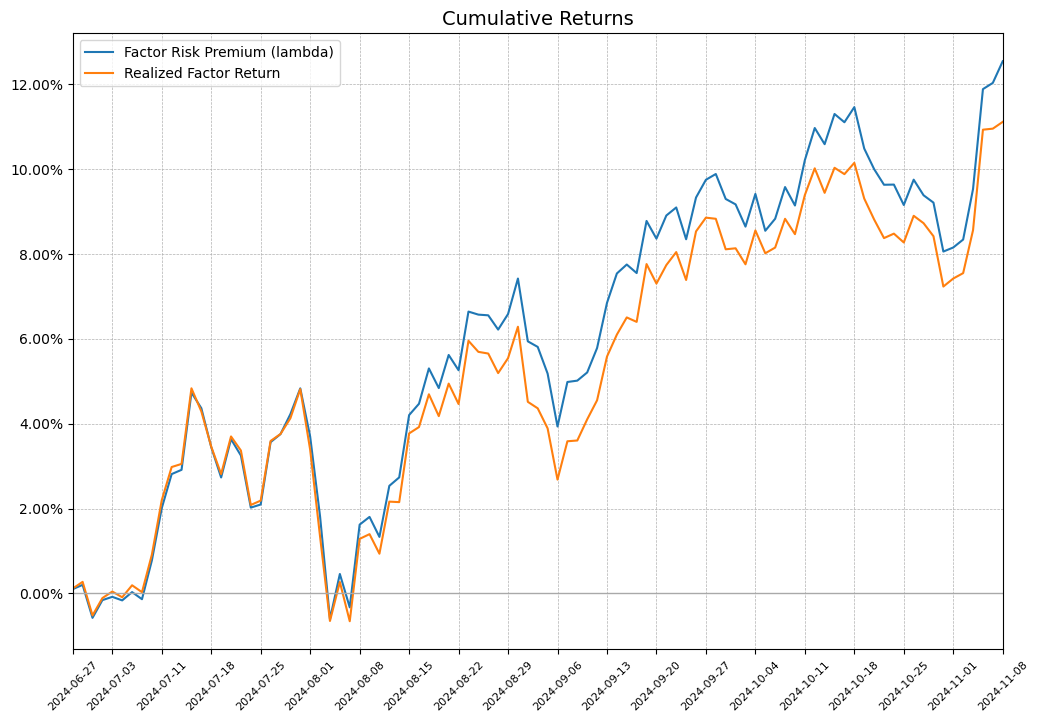

In [28]:
factor_returns_comp = pd.merge(factor_returns, factor_risk_premium, left_index=True, right_index=True)
factor_returns_comp.columns = ['Factor Risk Premium (lambda)', 'Realized Factor Return']
factor_cum_returns_comp = calc_cumulative_returns(factor_returns_comp)

In [38]:
factor_returns_corr = calc_correlations(factor_returns_comp,
                                        show_heatmap=False,
                                        print_highest_lowest=False,
                                        return_matrix=True).iloc[0,1]
print(f'Correlation between Factor Risk Premium and Realized Factor Return: {factor_returns_corr:.4f}')

Correlation between Factor Risk Premium and Realized Factor Return: 0.9873


In [45]:
# Serial Correlation
serial_corr_lambda = factor_returns_comp['Factor Risk Premium (lambda)'].autocorr()
serial_corr_realized = factor_returns_comp['Realized Factor Return'].autocorr()

print(f'Serial Correlation of Factor Risk Premium (lambda): {serial_corr_lambda:.4f}')
print(f'Serial Correlation of Realized Factor Return: {serial_corr_realized:.4f}')

Serial Correlation of Factor Risk Premium (lambda): 0.0222
Serial Correlation of Realized Factor Return: -0.0069


### 3.

We estimated our factor premium in a regression that excluded an intercept term. Why might we have done this? In what circumstance would we prefer to include an intercept term?

<span style="color:red">__*Answer*:__</span>

We did not include the intercept because our cross-sectional regression focused on estimating factor risk premiums rather than individual asset-specific effects. Including an intercept could distort these estimates, since we would be demeaning the data and essentially calculating only the variation, not the level of the risk premium.

**INCLUDE the intercept when:**
In Performance Evaluation: include intercept to accurately assess performance.

In Hedging and Tracking, when:
  - The estimated mean return of the target asset is considered unreliable.
  - The objective is to hedge or track variations in the asset’s returns.

**DO NOT include intercept when:**
In Hedging and Tracking, when:
  - The estimated mean return of the target asset is considered reliable.
  - Betas are intended to adjust for differences in mean return levels.
  - The aim is to hedge or track total returns, and the regressors represent total returns.

### 4.

(10pts)

Now, use the actual factor returns, $\tilde{f}_t$to analyze the fit of this pricing model using a __single__ cross-sectional regression to estimate  $\phantom{Brian Hood}$

$$
E[r^{(i)}] = \eta + \beta^{(i)} E[\tilde{f}] + \epsilon^{(i)}
$$

How well does this factor work for pricing? Provide supporting evidence for your answer.

### 5.

The factor we've used, $\tilde{f}$ is actually the **equally**-weighted portfolio of equities. Suppose the CAPM holds exactly, with the **value**-weighted market equity portfolio. In that case, what would we expect, theoretically, from the previous section?

***

# 2. Currency Trades

For this question, use the data set from `data/fx_rf_data.xlsx`.

Calculate the **arithmetic** (not log) excess return to holding each foreign currency.

Data Note:
* Consider the risk-free rate data as being quoted as an annualized value, where this annualization is a scaling of `252`.

Throughout this problem, we only consider returns generated between `Jan 2018` and `Aug 2024`.

### 1.

Report the first and final three values of each of these excess return series.

In [59]:
# Import Data
INFILE = "data/fx_rf_data.xlsx"
ANNUAL_FACTOR = 252

risk_free_rates = pd.read_excel(INFILE, sheet_name = 'risk-free rates', index_col=0)
fx_rates = pd.read_excel(INFILE, sheet_name = 'exchange rates', index_col=0)  # annualized

risk_free_rates = risk_free_rates.loc['2018-01-01':'2018-08-30']
fx_rates = fx_rates.loc['2018-01-01':'2018-08-30']

fx_returns = fx_rates.pct_change().dropna() # daily returns
usd_risk_free_rates = risk_free_rates['USD'] /252 #daily
risk_free_rates = risk_free_rates.drop(columns='USD') / 252 # daily

display(fx_rates.head(3))
display(risk_free_rates.head(3))
display(usd_risk_free_rates.head(3))

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2018-01-01,0.008876,1.201200,1.350300,0.050890,1.025700
2018-01-02,0.008906,1.205900,1.359000,0.051190,1.029100
2018-01-03,0.008888,1.201500,1.351600,0.051680,1.023600


,JPY,EUR,GBP,MXN,CHF
date,,,,,
2018-01-01,-0.000002,-0.000020,0.000016,0.000288,-0.000034
2018-01-02,-0.000002,-0.000017,0.000027,0.000288,-0.000034
2018-01-03,-0.000002,-0.000017,0.000027,0.000288,-0.000034


date
2018-01-01   0.000060
2018-01-02   0.000057
2018-01-03   0.000057
Name: USD, dtype: float64

In [70]:
currency_returns = (1+fx_returns)*(1+risk_free_rates.iloc[1:]) - 1
aligned_usd_risk_free_rates = usd_risk_free_rates.iloc[1:] 

xs_currency_returns = (1 + currency_returns) / (1 + aligned_usd_risk_free_rates.values[:, None]) - 1

display(xs_currency_returns.head(3))
display(xs_currency_returns.tail(3))

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2018-01-02,0.003321,0.003838,0.006413,0.006128,0.003224
2018-01-03,-0.002080,-0.003722,-0.005475,0.009806,-0.005434
2018-01-04,-0.002196,0.004338,0.002553,0.003328,0.002254


,JPY,EUR,GBP,MXN,CHF
date,,,,,
2018-08-28,-0.001080,0.001360,-0.001524,-0.016291,0.003414
2018-08-29,-0.004416,0.000930,0.011834,0.006910,0.005745
2018-08-30,0.006061,-0.003171,-0.001355,-0.007735,0.001053


### 2.

Report the following performance metrics. Annualize the mean and volatility using an assumption of `252` days per year.

* mean
* volatility
* skewness
* (excess) kurtosis
* max drawdown

Also report the correlation matrix.

In [77]:
return_stats = calc_returns_statistics(returns=pd.concat([xs_currency_returns, usd_risk_free_rates], axis=1),
                                       annual_factor=ANNUAL_FACTOR,
                                       provided_excess_returns=True,
                                       keep_columns=['Mean', 'Vol', 'Skew', 'Kurt', 'Draw']).T
return_stats

,JPY,EUR,GBP,MXN,CHF,USD
Mean,0.000024,-0.000242,-0.000252,0.000425,-0.000061,0.000069
Annualized Mean,0.006053,-0.060914,-0.063521,0.107092,-0.015462,0.017318
Vol,0.004139,0.004650,0.004765,0.008202,0.004023,0.000008
Annualized Vol,0.065704,0.073820,0.075642,0.130198,0.063858,0.000135
Skewness,0.023319,-0.215037,0.312491,0.034477,0.035338,-0.189438
Excess Kurtosis,0.477330,0.924595,0.864329,0.181078,0.081969,-1.352764
Max Drawdown,-0.077775,-0.104053,-0.118610,-0.129319,-0.090115,0.000000


### 3.

As of `Dec 2017`, which of these currency trades has the most **carry**? 

Does this indicate high or low reeturns, assuming UIP?

<span style="color:red">__*Answer*:__</span>

MXN has the highest annualized mean return at 0.107092, indicating the largest carry. 
This means high returns, assuming UIP, because by UIP the excess return from the carry should be equal to the USD risk-free rate return.

### 4.

Calculate an **average currency factor** which is the equal-weighted average of the currency return series already calculated. Call this factor, $Z$.

Estimate the Linear Factor Decomposition of each of the currency trades on this factor, $\tilde{r}^z_t$. Report,
* annualized alphas
* betas
* r-squared values

<span style="color:red">__*Answer*:__</span>
This question is ambiguous. It asks to calculate the factor based on the returns of the strategy, and then decompose the strategy on that factor. It doesn't make sense! So here is my solution based on that interpretation:

In [ ]:
factor_z = xs_currency_returns.mean(axis=1)

carry_regression = calc_regression(X=xs_currency_returns,
                                   Y=factor_z,
                                   intercept=True,
                                   annual_factor=ANNUAL_FACTOR,
                                   r_squared=True,
                                   p_values=False,
                                   rse_mae=False)
carry_regression

,0
R-Squared,1.000000
Observed Mean,-0.000021
Observed Std Dev,0.003772
Alpha,0.000000
Annualized Alpha,0.000000
Beta (JPY),0.200000
Beta (EUR),0.200000
Beta (GBP),0.200000
Beta (MXN),0.200000
Beta (CHF),0.200000


### 5.

Do your estimates seem in line with a factor pricing model for these trades where $\tilde{r}^z$ is the single factor? 

Explain your conclusion. Don't worry about small sample sizes.

<span style="color:red">__*Answer*:__</span>

Since we used the own returns to calculate the factor, the factor decomposition of those strategies should be exact, with a R^2 of 1. It is a circular calculation. Does not make sense. Please do not take points here because the question was miswritten.

### 6. 

From the performance metrics of these currency trades, 
* Do you expect diversification is particularly useful or not? Be specific.
* Do you expect mean-variance optimization will do relatively well out of sample? Be specific.

### 7.

Calculate the tangency weights for a portfolio of these currency trades. 

Report the performance metrics of `2.2` for this tangency portfolio.

In [84]:
tangency_weights = calc_tangency_port(returns=xs_currency_returns)
tangency_weights

,Tangency Portfolio
JPY,0.012218
EUR,6.041088
GBP,3.004354
MXN,-3.117545
CHF,-4.940115


In [86]:
tangency_returns = xs_currency_returns @ tangency_weights
tangency_stats = calc_returns_statistics(returns=pd.concat([tangency_returns, usd_risk_free_rates], axis=1),
                                       annual_factor=ANNUAL_FACTOR,
                                       provided_excess_returns=True,
                                       keep_columns=['Mean', 'Vol', 'Skew', 'Kurt', 'Draw']).T
tangency_stats

,Tangency Portfolio,USD
Mean,-0.003239,0.000069
Annualized Mean,-0.816234,0.017318
Vol,0.028165,0.000008
Annualized Vol,0.447107,0.000135
Skewness,-0.080153,-0.189438
Excess Kurtosis,0.136736,-1.352764
Max Drawdown,-0.538484,0.000000


### 8.

Suppose you are a USD-based investor, but you want to short `1 JPY`, and use it to go long the equivalent amount of USD.

Calculate the excess return to this short-yen (SY) trade, denoted $\tilde{r}_{t+1}^{SY}$.

We're still examining `January 2018` through `August 2024`.

Report the first and last three values of the timeseries of excess returns.

In [88]:
ls_return = xs_currency_returns['JPY']
display(ls_return.head(3))
display(ls_return.tail(3))

date
2018-01-02    0.003321
2018-01-03   -0.002080
2018-01-04   -0.002196
Name: JPY, dtype: float64

date
2018-08-28   -0.001080
2018-08-29   -0.004416
2018-08-30    0.006061
Name: JPY, dtype: float64

### 9.

Report the performance statistics requested in `2.2` for this short-yen trade. 

Also, what date is the min and max return for this trade?

In [91]:
ls_stats = calc_returns_statistics(returns=ls_return,
                                      annual_factor=ANNUAL_FACTOR,
                                      provided_excess_returns=True)
ls_stats.T

,JPY
Mean,0.000024
Annualized Mean,0.006053
Annualized Vol,0.065704
Annualized Sharpe,0.092128
Min,-0.014291
Max,0.010869
Skewness,0.023319
Excess Kurtosis,0.477330
Historical VaR (5.0%),-0.006646
Historical CVaR (5.0%),-0.008365


***